# Checkpoint 5

Import Required Libraries

In [228]:
import numpy as np 
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.stats import chi2
import math
import matplotlib.pyplot as plt
from scipy.special import erfinv,erf
from iminuit import Minuit as im


XMIN = 0.
XMAX = 20.
intercept = 20.
slope = -1.
# signal parameters
mean = 10.
sigma = 0.5
NBINS = 100
NEVENTS = 10000

## Classes

### Linear Class

In [229]:
class Linear:
    """Generates Linear Class with parameters for linear function.
    """
    def __init__(self, XMIN,XMAX,intercept,slope):
        self.mass = []

        self.lolimit = XMIN
        self.hilimit = XMAX
        self.intercept = intercept
        self.slope = slope
      
        
    def evaluate(self,inp):
        """Evaluates linear function at input(inp)

        Args:
            input (float, Numpy Array): Any number that needs to be mapped

        Returns:
            float, Numpy Array: input mapped onto a linear function
        """
        return self.intercept + self.slope * inp
    
    def maxval(self):
        """
        Returns:
            float : Maximum value of the linear function of the class.
        """
        return np.amax([self.evaluate(self.hilimit),self.evaluate(self.lolimit)]) + np.random.uniform()
    
    def integral(self, imin=False,imax=False):
        """
        Integrates the Linear function output between a range.

        Args:
            imin (bool, float): The minimum for the integration range. Defaults to Class MIN.
            imax (bool, optional): The maximum for integration range. Defaults to Class MAX.

        Returns:
            _type_: _description_
        """
        imin = self.lolimit if not imin else imin
        imax = self.hilimit if not imax else imax
        return integrate.quad(self.evaluate, imin, imax)[0]
                    
    def next(self,events):
        """ Generates float Numpy Array containing events from a Linear PDF of the class.

        Args:
            events (int): Number of events to simulate

        Returns:
            Numpy Array : Events from a Linear PDF of the class
        """
        global XMIN ,XMAX
     
        filtered_x = np.random.uniform(XMIN, XMAX,size=events)
        y1 = self.evaluate(filtered_x)
        y2 = np.random.uniform(XMIN, XMAX,size=events)
        # %%
        left_filtered = np.where(~(y2<y1))[0] #numbers that do are not under linear function
        
        # %%
        #replace every random nonadherent number with another random one that follows condition
        while(len(left_filtered) != 0):
            filtered_x[left_filtered] = np.random.uniform(XMIN, XMAX,size=len(left_filtered))
            y1 = self.evaluate(filtered_x)
            y2[left_filtered] = np.random.uniform(XMIN, XMAX,size=len(left_filtered))
            left_filtered = np.where(~(y2 < y1))[0]
        self.mass = filtered_x
        return filtered_x

    
 
              


### Gaussian


In [230]:
class Gaussian:
    """Generates Gaussian Class with parameters for Gaussian function.
    """
    def __init__(self,mean=mean,sigma=sigma):
        self.mass = []
        self.mean = mean
        self.sigma = sigma
        
    def evaluate(self, inp):
        """Evaluates linear function at input(inp)
        Args:
            inp (f): _description_

        Returns:
            _type_: _description_
        """
        return np.exp(-(inp - self.mean)**2 / (2 * self.sigma**2)) # where 1 was amplitude initially
    
    def integral(self, imin=False,imax=False):
        
        imin = self.mean - 5*self.sigma if not imin else imin
        imax = self.mean + 5*self.sigma if not imax else imax
        
          
        return integrate.quad(self.evaluate,imin,imax,points=[self.mean])[0]
    
    def next(self,events): 
        return np.random.normal(loc=self.mean, scale=self.sigma,size=events)

### Signal With Background

In [231]:
class SignalWithBackground:
    
    def __init__(self, mean, sigma, sig_fraction, intercept, slope, XMIN, XMAX):
        self.mass_sig = []
        self.mass_bgd = []
        self.mass = 0
        
        
        self.signal = Gaussian(mean,sigma)
        self.background = Linear(XMIN,XMAX,intercept,slope)
        self.sig_fraction = sig_fraction
  

    # Draw random number form distribution
    def next(self,events):
        # given to us in exmaple
        # q = np.random.uniform() 
        # if( q < self.sig_fraction):
        # # if here, we will draw x from signal distribution
        #     filtered_x = self.signal.next()
        #     self.mass_sig.append(filtered_x)
        # else:
        #     # if here, we will draw x from background distribuion
        #     filtered_x = self.background.next() 
        #     self.mass_bgd.append(filtered_x)
        # self.mass.append(filtered_x) 
        # return filtered_x
        
        self.mass = np.zeros(events)
        q = np.random.uniform(size=events)
        p = np.where(q<self.sig_fraction)[0]
        self.mass_sig = self.mass[p] = self.signal.next(len(p))
        self.mass_bgd = self.mass[~(q<self.sig_fraction)] = self.background.next(len(q)-len(p))

## Problem 1 : Simple Toy

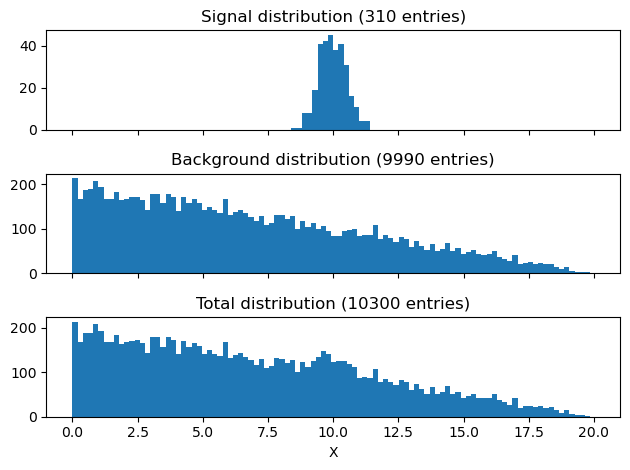

In [232]:
def singleToy(nevents_sig = 300, nevents_bgd = 10000,save_plot=True):
    total_events = nevents_bgd + nevents_sig
    sig_fraction = nevents_sig/total_events
#   Create the pdf
    pdf = SignalWithBackground(mean, sigma, sig_fraction, intercept, slope, XMIN, XMAX ) 
    # for i in range( nevents_sig + nevents_bgd ): 
    pdf.next(total_events)
    # retrieve the mass values for signal, background and their sum
    data = pdf.mass 
    sig_data = pdf.mass_sig 
    bgd_data = pdf.mass_bgd
    # plot things on same page
    
    myRange = (XMIN, XMAX)
    fig, axs = plt.subplots(3,1, sharex='col')
    axs[0].set_title("Signal distribution (" + str(len(sig_data)) + " entries)") 
    axs[1].set_title("Background distribution (" + str(len(bgd_data)) + " entries)") 
    axs[2].set_title("Total distribution (" + str(len(data)) + " entries)") 
    axs[2].set_xlabel('X')
    axs[0].hist(sig_data, bins=NBINS, range=myRange) 
    axs[1].hist(bgd_data, bins = NBINS) 
    axs[2].hist(data, bins = NBINS) 
    fig.tight_layout()
    if save_plot:
        plt.savefig('Example1.pdf')
 

    
singleToy()

In the third plot, there is a clear peak where the signal is ought to be but it could be due to our visual bias had we not known about the original signal in the first place. 

## Problem 2 : Quantifying Background Fluctuations

In [233]:
mean_hits = NEVENTS
sigma_poisson = np.sqrt(mean_hits)

poisson_bgd = Gaussian(mean_hits,sigma_poisson)

p_value = poisson_bgd.integral(imin=mean_hits+300)/poisson_bgd.integral()
n_sigma = erfinv(1 - p_value) * np.sqrt(2)
print("p-value: {:.5f} and n-sigma: {:.0f}".format(p_value, n_sigma))

p-value: 0.00135 and n-sigma: 3


There is a 0.135% probability that a background only process with mean number of events at 10,000 can fluctaute to more than 10,300 events. These events atleast 3 sigma deviation away from the mean.

## Problem 3

**Confirmation of Number of Background Events.**

From the output it can be confirmed that 50% of the background events are in the region x = 5 and x = 15

In [234]:
bgd = Linear(XMIN,XMAX,intercept,slope) #Linear Object for the background range
bgd_fraction = bgd.integral(5,15)/bgd.integral() #fractional integral area within the range


print("background fraction in (5,15) range is {}%".format(bgd_fraction*100))



background fraction in (5,15) range is 50.0%


**p-value and Z score for the subregion (5,15)**

In [235]:
# Poisson parameters for the subregion distribution
mean_hits = NEVENTS*bgd_fraction 
sigma_poisson = np.sqrt(mean_hits) 


poisson_bgd = Gaussian(mean_hits,sigma_poisson) # Gaussian class estimating Poisson for subregion
p_value = poisson_bgd.integral(imin=mean_hits+300)/poisson_bgd.integral()
print(p_value)

n_sigma = erfinv(1 - p_value) * np.sqrt(2)
print("p-value: {:.5f} and n-sigma: {:.0f}".format(p_value, n_sigma))

1.0758603095354499e-05
p-value: 0.00001 and n-sigma: 4


The deviation is much more signifcant, there is a 1 sigma difference. The p-value is also significantly smaller. The number of events to imply signal is still constant and is comparatively larger in ratio with the background events if we reduce our region of background events. The number of events in the  reduced region are less likely to deviate as far.

This is also analogous to the idea that if we know where to look at, we are more likely to find it.

## Problem 4

**Generating a Toy with 150 signal events.**

In [236]:

nevents_sig = 150
nevents_bgd = 10000
total_events = nevents_bgd + nevents_sig
sig_ratio = nevents_sig/total_events
x = 0 #initializing the dataset for the experiment


In [1]:
def nll(y0,m,F):
    """Negative Log-likelihood Function

    Args:
        y0 (float): Intercept
        m (float): slope
        F (float): Signal Fraction

    Returns:
        float : Negative Log likelihood of the Signal with Background events
    """
    h0_component = y0 + m * x #linear equation
    normf_h0_component = 20*(10*m+y0) #normalization factor
    norm_h0 = h0_component/normf_h0_component #normalised equation

   
    signal_component = np.exp(-(x - mean)**2 / (2 * sigma**2)) #Gaussian equation with fixed mean and sigma
    const = np.sqrt(2)*sigma #just a constant
    normf_signal = np.sqrt(np.pi/2)*sigma*(erf(mean/const)   -  erf((mean-20)/const)) # normalization factor 
    norm_signal = signal_component/normf_signal #normalized equation
    
    P =   (1-F)*norm_h0 + (F)*norm_signal #combined equation
    
    return -np.sum(np.log(P))

def h0_fit(fn):
    """
    Carries out H0 fit

    Args:
        fn (function): NLL function

    Returns:
        iminuit object : iminuit object contaning the likelihood fit
    """
    m_h0 = im(fn,y0=intercept, m=slope,F=0)
    m_h0.fixed['F'] = True #fixing 
    m_h0.errordef = 0.5
    m_h0.migrad()
    return m_h0

def h1_fit(fn):
    """
    Carries out the H1 fit

    Args:
        fn (function): NLL function

    Returns:
        iminuit object : iminuit object contaning the likelihood fit
    """
    m_h1 = im(fn,y0=intercept,m=slope,F=sig_ratio)
    m_h1.errordef = 0.5
    m_h1.migrad()
    return m_h1
    
def nll_diff(m0,m1):
    """Hypothesis Testing Parameters for NLL

    Args:
        m0 (iminuit object): iminuit for H0
        m1 (iminuit object): iminuit for H1

    Returns:
        float: Chi-square like difference
        float: p-value
        float: Z-score / n-sigma
    """
    dX2= 2*abs(nll(*m0.values[0:])-nll(*m1.values[0:]))
    p_value = 1-chi2.cdf(dX2,1)
    n_sigma = erfinv(1 - p_value) * np.sqrt(2)
    return dX2, p_value, n_sigma

def mc_exp():
    """
    The function generates a simulated data with Signal and Backgorund. 
    The data undergoes both H0 and H1 fit. The HYpothesis testing parameters are returned.

    Returns:
        float: Chi-square like difference
        float: p-value
        float: Z-score / n-sigma 
    """
    global x
    pdf = SignalWithBackground(mean, sigma, sig_ratio, intercept, slope, XMIN, XMAX ) 
    pdf.next(total_events)
    x = pdf.mass
    
    return nll_diff(h0_fit(nll),h1_fit(nll))



  
    
    

In [256]:
dX2_ouput,p_value_output,n_sigma_output = mc_exp()
print("NLL/X2 equivalent(rounded to 5 s.f): {:.5f} p-value(rounded to 5 s.f): {:.5f} and n-sigma: {:.0f}".format(dX2_ouput,p_value_output, n_sigma_output))

NLL/X2 equivalent(rounded to 5 s.f): 10.21714 p-value(rounded to 5 s.f): 0.00139 and n-sigma: 3


In [262]:
print("Probability of this X2 is {:.0f} in 10,000 experiments(rounded to the nearest integer".format(p_value_output*10000))

Probability of this X2 is 14 in 10,000 experiments


Extra : variation in the X2 value. Just to see how much the X2 varies.

/var/folders/2f/y14hzqx53r56d9npnh5jl95m0000gp/T/ipykernel_24473/2638949553.py:24: RuntimeWarning: invalid value encountered in log
  return -np.sum(np.log(P))


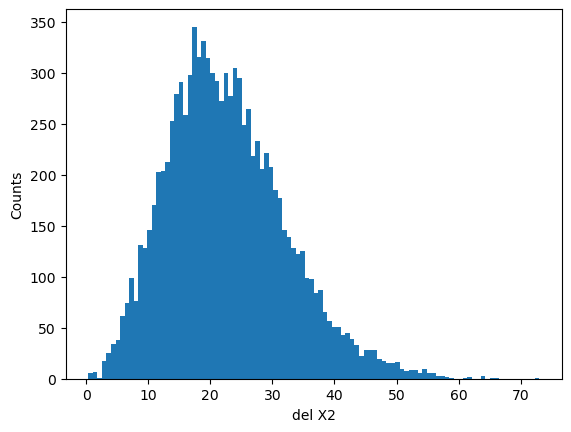

In [297]:
N_MC = int(1e+4)
mc_x2 = np.empty(N_MC)
for i in range(N_MC):
    
    mc_x2[i] = mc_exp()[0]
    
plt.hist(mc_x2,bins=100)
plt.xlabel("del X2")
plt.ylabel("Counts")
plt.show()

### Problem 5

In [258]:
def mc_exp_bgd():
    """
    The function generates a simulated data with Backgorund only events. 
    The data undergoes both H0 and H1 fit. The HYpothesis testing parameters are returned.

    Returns:
        float: Chi-square like difference
        float: p-value
        float: Z-score / n-sigma 
    """
    global x
    pdf = SignalWithBackground(mean, sigma, 0, intercept, slope, XMIN, XMAX ) 
    pdf.next(total_events)
    x = pdf.mass
    
    return nll_diff(h0_fit(nll),h1_fit(nll))

In [259]:
N_MC = int(1e+4)
mc_nsigma = np.empty(N_MC)
for i in range(N_MC):
    
    mc_nsigma[i] = mc_exp_bgd()[0]

/var/folders/2f/y14hzqx53r56d9npnh5jl95m0000gp/T/ipykernel_24473/2638949553.py:24: RuntimeWarning: invalid value encountered in log
  return -np.sum(np.log(P))


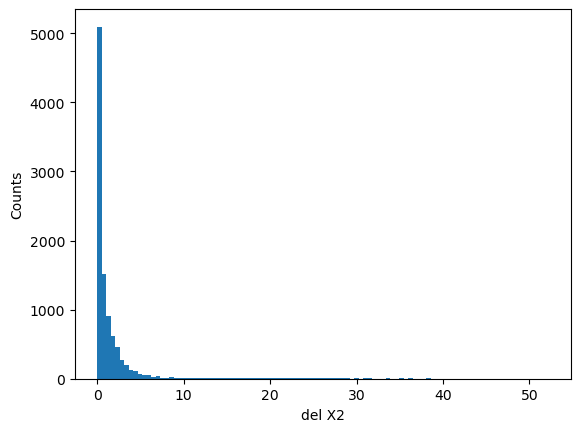

In [283]:
plt.hist(mc_nsigma,bins=100)
plt.xlabel("del X2")
plt.ylabel("Counts")
plt.show()

In [296]:
probability_check_for_X2 = np.where(np.isclose(mc_nsigma,dX2_ouput,rtol=0.025))[0]
print(probability_check_for_X2.size)

14


The delta Chi-square like value we achieved was around 10.22. With 10,0000 experiments we are likely to see 14 experiments with similar chi square value out of 10,000. Using 10,000 runs in a Monte Carlo simulation, we see 14 such runs considering a tolerance of 2.5%. Wilks Theorem predicts the anomalous behaviour that we see in our Monete Carlo experiment. And they seem to agree that this is a rare occurence. If our model predicts a signal it is very unlikely that it is simply some anomalous behvaiour from the background.

Looking at the previous graph, it is clear that majority of del X2 is between 10-30, which is region of rare occurrence from the Monte-Carlo experiment. Using the monte-carlo, It is very unlikely that fluctuations from background will be mistaken for signal using our current model.